In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
import cv2
import random
import matplotlib
import matplotlib.pyplot as plt



In [2]:
class1_folder = './Data/train/fractured'
class2_folder = './Data/train/not fractured'

In [3]:

input_shape = (224, 224, 3)  # Input shape for the model
batch_size = 32
epochs = 15


In [4]:

# Load and preprocess images
def load_and_preprocess_images(folder_path, label):
    images = []
    for image_filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (input_shape[0], input_shape[1]))
        images.append(image)
    labels = [label] * len(images)
    return images, labels

class1_images, class1_labels = load_and_preprocess_images(class1_folder, label=0)
class2_images, class2_labels = load_and_preprocess_images(class2_folder, label=1)

# Combine the datasets and labels
all_images = class1_images + class2_images
all_labels = class1_labels + class2_labels


In [5]:

# Apply Canny edge detection
def apply_canny_edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    return edges_rgb

canny_images = [apply_canny_edge_detection(image) for image in all_images]


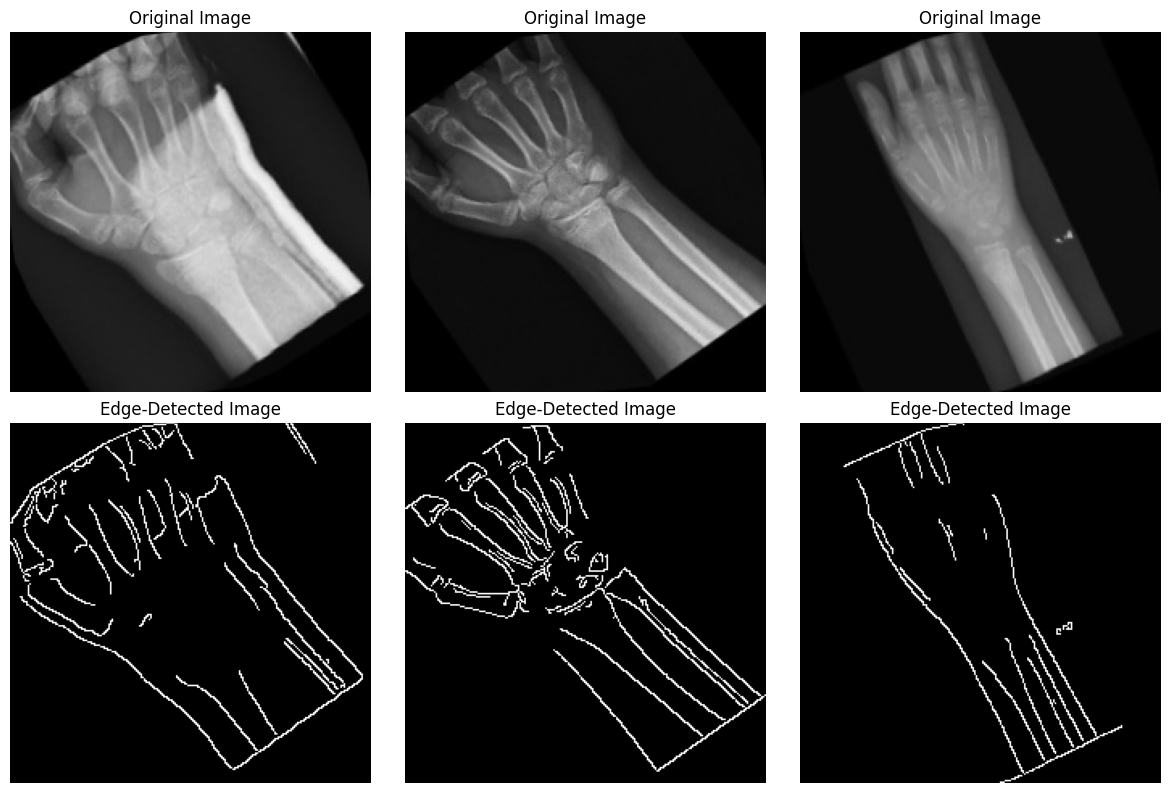

In [6]:

def display_random_images(images, num_images=3):
    random_images = random.sample(images, num_images)
    plt.figure(figsize=(12, 8))
    
    for i, image in enumerate(random_images):
        # Original image
        original_image = image
        
        # Apply edge detection
        edge_detected_image = apply_canny_edge_detection(original_image)
        
        # Plotting original and edge-detected images side by side
        plt.subplot(2, num_images, i+1)
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Original Image')
        
        plt.subplot(2, num_images, num_images+i+1)
        plt.imshow(edge_detected_image, cmap='gray')
        plt.axis('off')
        plt.title('Edge-Detected Image')
    
    plt.tight_layout()
    plt.show()

# Display random original and edge-detected images
display_random_images(class1_images, num_images=3)

In [7]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(canny_images, all_labels, test_size=0.2, random_state=42)


In [8]:
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 1536)       0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                        

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','AUC'])

In [10]:
from keras.utils.data_utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.x_data))
        batch_indexes = self.indexes[start_idx:end_idx]
        batch_x = [self.x_data[i] for i in batch_indexes]
        batch_y = [self.y_data[i] for i in batch_indexes]
        return np.array(batch_x), np.array(batch_y)

# Create custom data generators
train_generator = CustomDataGenerator(X_train, y_train, batch_size=batch_size)
val_generator = CustomDataGenerator(X_val, y_val, batch_size=batch_size)

# Train the model using custom data generators
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    steps_per_epoch=50,
)


Epoch 1/15
50/50 [==============================] - 209s 4s/step - loss: 0.7248 - accuracy: 0.6999 - precision: 0.6926 - recall: 0.6979 - auc: 0.7743 - val_loss: 0.7994 - val_accuracy: 0.5606 - val_precision: 0.5294 - val_recall: 0.9977 - val_auc: 0.8736
Epoch 2/15
50/50 [==============================] - 184s 4s/step - loss: 0.4709 - accuracy: 0.7950 - precision: 0.7834 - recall: 0.8053 - auc: 0.8682 - val_loss: 0.4157 - val_accuracy: 0.8201 - val_precision: 0.7650 - val_recall: 0.9178 - val_auc: 0.9224
Epoch 3/15
50/50 [==============================] - 182s 4s/step - loss: 0.3758 - accuracy: 0.8344 - precision: 0.8344 - recall: 0.8248 - auc: 0.9126 - val_loss: 0.3471 - val_accuracy: 0.8556 - val_precision: 0.8202 - val_recall: 0.9064 - val_auc: 0.9434
Epoch 4/15
50/50 [==============================] - 176s 4s/step - loss: 0.3548 - accuracy: 0.8431 - precision: 0.8414 - recall: 0.8338 - auc: 0.9226 - val_loss: 0.3070 - val_accuracy: 0.8872 - val_precision: 0.8674 - val_recall: 0.911

In [11]:
val_results = model.evaluate(val_generator)

print("Validation Loss:", val_results[0])
print("Validation Accuracy:", val_results[1])


56/56 [==============================] - 107s 2s/step - loss: 0.1637 - accuracy: 0.9391 - precision: 0.9156 - recall: 0.9658 - auc: 0.9859
Validation Loss: 0.1636633425951004
Validation Accuracy: 0.9390863180160522


In [12]:
val_results

[0.1636633425951004,
 0.9390863180160522,
 0.9155844449996948,
 0.965753436088562,
 0.9859405755996704]

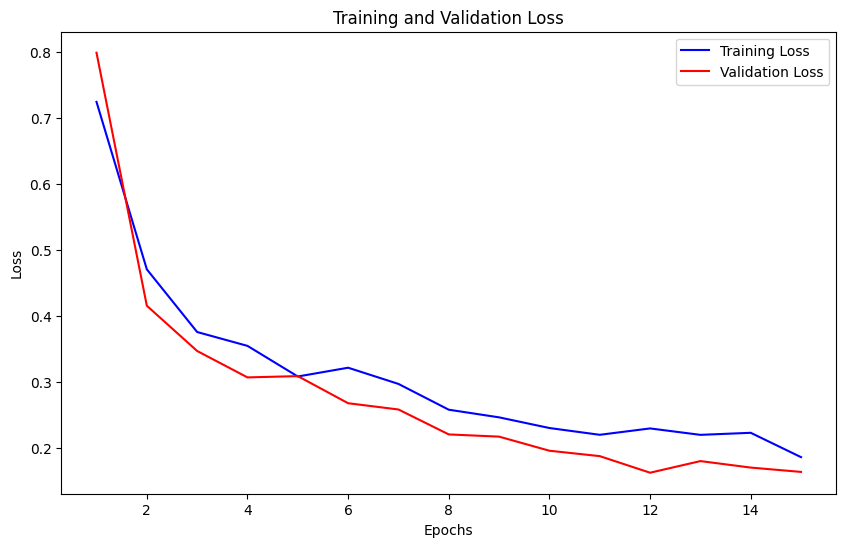

In [16]:
import matplotlib.pyplot as plt

# Get training and validation loss from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, len(training_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


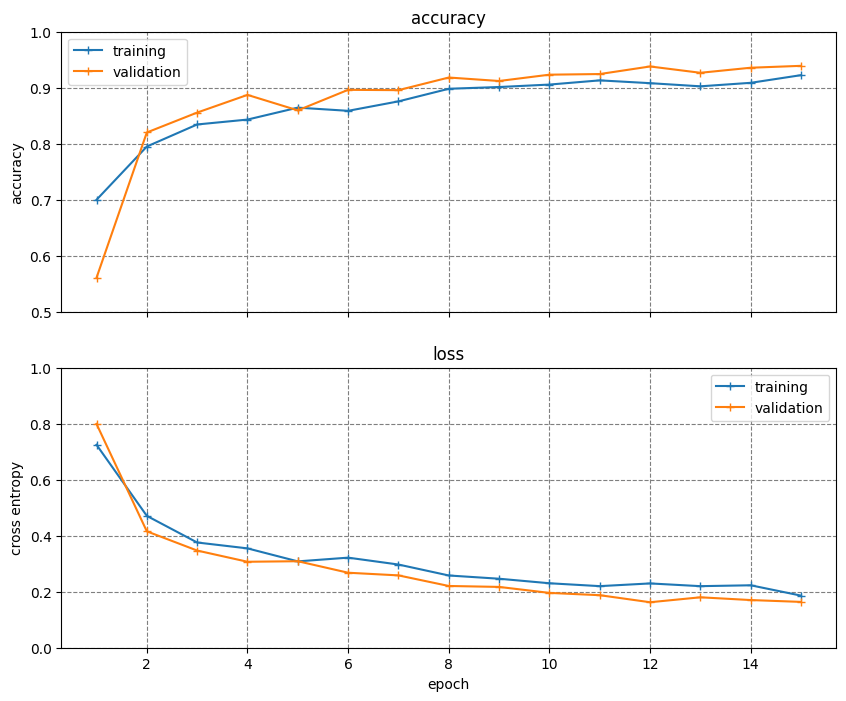

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = range(1, len(training_loss) + 1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities on validation data
y_pred_prob = model.predict(val_generator)

# # Calculate ROC curve
# fpr, tpr, thresholds = roc_curve(val_generator.labels, y_pred_prob)

# # Calculate AUC
# roc_auc = roc_auc_score(val_generator.labels, y_pred_prob)

# # Plot ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()


56/56 [==============================] - 95s 2s/step


AttributeError: 'CustomDataGenerator' object has no attribute 'labels'

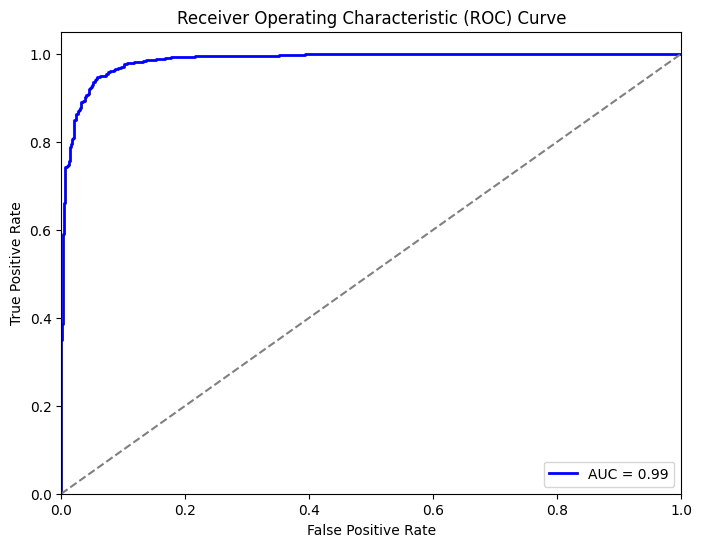

In [25]:
# Extract true labels from the custom data generator
true_labels = []
for i in range(len(val_generator)):
    _, batch_labels = val_generator[i]
    true_labels.extend(batch_labels)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, y_pred_prob)

# Calculate AUC
roc_auc = roc_auc_score(true_labels, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()